# Skrinning Stuff

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt

import solarpy
import datetime

currentDir = os.getcwd()
sys.path.append(os.path.join(currentDir, '../code/'))
import geomUtils as geom
import IceSheet

In [2]:
geom.charLength('hex', [2.])

1.7320508075688774

In [3]:
diamsCrystal = np.array([0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.])  # m
gapMelt = 1.e-4  # m

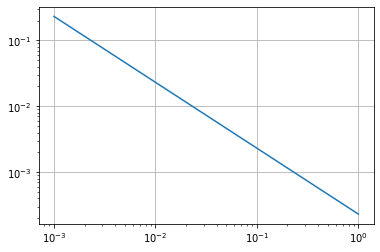

In [4]:
porosities = [(geom.periphery('hex', [x])*gapMelt/2)/(geom.area('hex', [x])) for x in diamsCrystal]
plt.loglog(diamsCrystal, porosities)
plt.grid()

In [5]:
# myIce = IceSheet.IceSheet(iceType='blackIce', thickness=100.0, crystalSize=100.0)

In [6]:
# spatialNodeCount = 51
# timeStepCount = 101
# timeStep = 120  # s

In [7]:
# A, B, b, U0 = myIce.setupModel(IC=[-1., 0.], windSpeed=5., aEnv=[0.15, 0.75, 0.1], TEnv=[-2.0, -20.0, -270.], S0=300., Nz=spatialNodeCount, tStep=timeStep)
# A

In [8]:
# Us = []
# Us.append(U0)
# U = U0

# for idx in range(1, timeStepCount):
#     U = np.linalg.solve(A, B.dot(U) + b)
#     Us.append(U)
    
# USoln = np.array(Us)

**TODO** Need to get dx, dy, zStep, tStep, zScale, tScale from myIce

In [9]:
# timeIndeces = np.array([0, 1, 2, 5, 10, 30, timeStepCount-1])

# THi = 0.
# TLo = -2.
# TSoln = USoln*(THi - TLo) + TLo
# z = np.linspace(0, spatialNodeCount, spatialNodeCount)*myIce._h0/spatialNodeCount*100  # cm
# t = np.linspace(0, timeStepCount, timeStepCount)*8770./timeStepCount/3660  # h

# fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# for timeIndex in timeIndeces:
#     i = 0
#     axs[i].plot(range(spatialNodeCount), USoln[timeIndex, :], label='y node = '+'{}'.format(timeIndex))
#     i = 1
#     axs[i].plot(z, TSoln[timeIndex, :], label='t = '+'{:.2f} h'.format(t[timeIndex]))
# i = 0
# axs[i].set_xlabel('x node')
# axs[i].set_ylabel('U')
# i = 1
# axs[i].set_xlabel('z  / cm')
# axs[i].set_ylabel('T  / °C')
# for i in range(2):
#     axs[i].legend()
#     axs[i].grid()

### Simulate a Day or Two

In [10]:
# __init__
dateTimeStart = datetime.datetime(2021, 2, 21, 0, 0)
myIce = IceSheet.IceSheet(dateTime=dateTimeStart, sheet='blackIce', thickness=200.0, crystalSize=100.0, lat=55.71, alt=10)
myWater = IceSheet.IceSheet(dateTime=dateTimeStart, sheet='freshWater', thickness=1000.0, crystalSize=100.0, lat=55.71, alt=10)
myWater.setTransmittance(myIce)

When: 2021-02-21 00:00:00
Where: lat = 55.71°, alt = 10 m
What: blackIce
When: 2021-02-21 00:00:00
Where: lat = 55.71°, alt = 10 m
What: freshWater


In [11]:
# setupModel
spatialNodeCount = 51
timeStep = 5*60  # s
aEnv=[0.05, 0.9, 0.05]
TEnv=[-2.0, -20.0, -270.]
aEnvW=[1.]
TEnvW=[0.]

# get started
A, B, b, UInit = myIce.setupModel(IC=[-0.92, 0.], windSpeed=5., aEnv=aEnv, TEnv=TEnv, zNodes=spatialNodeCount, tStep=timeStep, isVerbose=True)
AW, BW, bW, UInitW = myWater.setupModel(IC=[0, 3.], windSpeed=5., aEnv=aEnv, TEnv=TEnv, zNodes=spatialNodeCount, tStep=timeStep, isVerbose=True)

thermal diffusivity a = 1.14e-06 m2/s
spatial stepsize dz = 4.00 mm
temporal stepsize dt = 300.00 s
timescale tScale = 35079.0 s
sigma = 10.690154021804274
irradiance S0 = 0 W/m2
thermal diffusivity a = 1.33e-07 m2/s
spatial stepsize dz = 20.00 mm
temporal stepsize dt = 300.00 s
timescale tScale = 7530636.4 s
sigma = 0.04979658805160749
irradiance S0 = 0 W/m2


In [12]:
# simulate
totalTime = 48*3600  # s
timeStepCount = totalTime//timeStep
timeStepCount

576

In [13]:
dateTimes, S0s, USoln, epsSoln = myIce.simulate(UInit, aEnv, TEnv, timeStepCount)
dateTimes, S0sW, USolnW, botMeltRates = myWater.simulate(UInitW, aEnvW, TEnvW, timeStepCount, 
                                                         TIce=myIce.makeUOneD(USoln), rhoIce=myIce._material['rho'], lambdaIce=myIce._material['lambda'], dxIce=myIce._dx, hIce=myIce._h)

In [14]:
idxSunUp = []
idxSunDn = []
for i in range(len(dateTimes)):
    if S0s[i] > 0 and S0s[i-1] == 0:
        idxSunUp.append(i)
    if S0s[i] == 0 and S0s[i-1] > 0:
        idxSunDn.append(i-1)
print(idxSunUp, idxSunDn)

[86, 373] [202, 491]


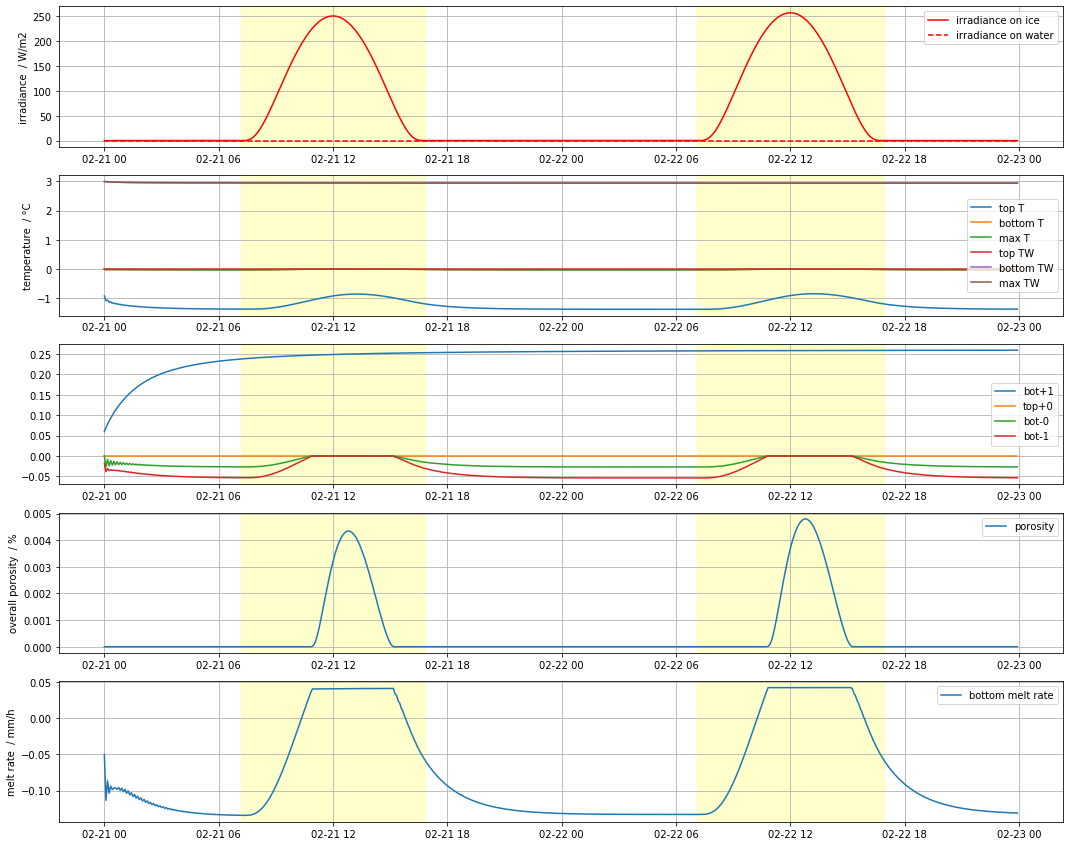

In [15]:
UMaxs = []
epss = []
UMaxsW = []
for j in range(len(USoln)):
    UMaxs.append(np.max(USoln[j, :]))
    epss.append(epsSoln[j].sum()*myIce._dx)
    UMaxsW.append(np.max(USolnW[j, :]))
epss = np.array(epss)

nPlot = 5
fig, axs = plt.subplots(nPlot, 1, figsize=(18, nPlot*3))
i = 0
axs[i].plot(dateTimes, S0s, color='red', label='irradiance on ice')
axs[i].plot(dateTimes, S0sW, '--', color='red', label='irradiance on water')
axs[i].set_ylabel('irradiance  / W/m2')
i = i + 1
axs[i].plot(dateTimes, myIce.makeUOneD(USoln[:, 0]), label='top T')
axs[i].plot(dateTimes, myIce.makeUOneD(USoln[:, -1]), label='bottom T')
axs[i].plot(dateTimes, myIce.makeUOneD(np.array(UMaxs)), label='max T')
axs[i].plot(dateTimes, myWater.makeUOneD(USolnW[:, 0]), label='top TW')
axs[i].plot(dateTimes, myWater.makeUOneD(USolnW[:, -1]), label='bottom TW')
axs[i].plot(dateTimes, myWater.makeUOneD(np.array(UMaxsW)), label='max TW')
axs[i].set_ylabel('temperature  / °C')
i = i + 1
axs[i].plot(dateTimes, myWater.makeUOneD(USolnW[:, 1]), label='bot+1')
axs[i].plot(dateTimes, myWater.makeUOneD(USolnW[:, 0]), label='top+0')
axs[i].plot(dateTimes, myIce.makeUOneD(USoln[:, -1]), label='bot-0')
axs[i].plot(dateTimes, myIce.makeUOneD(USoln[:, -2]), label='bot-1')
i = i + 1
axs[i].plot(dateTimes, epss*100, label='porosity')
axs[i].set_ylabel('overall porosity  / %')
i = i + 1
axs[i].plot(dateTimes, botMeltRates*1000*3600, label='bottom melt rate')
axs[i].set_ylabel('melt rate  / mm/h')
for i in range(nPlot):
    for j in range(len(idxSunUp)):
        axs[i].axvspan(dateTimes[idxSunUp[j]], dateTimes[idxSunDn[j]], color='yellow', alpha=0.2)
    axs[i].grid()
    axs[i].legend()    

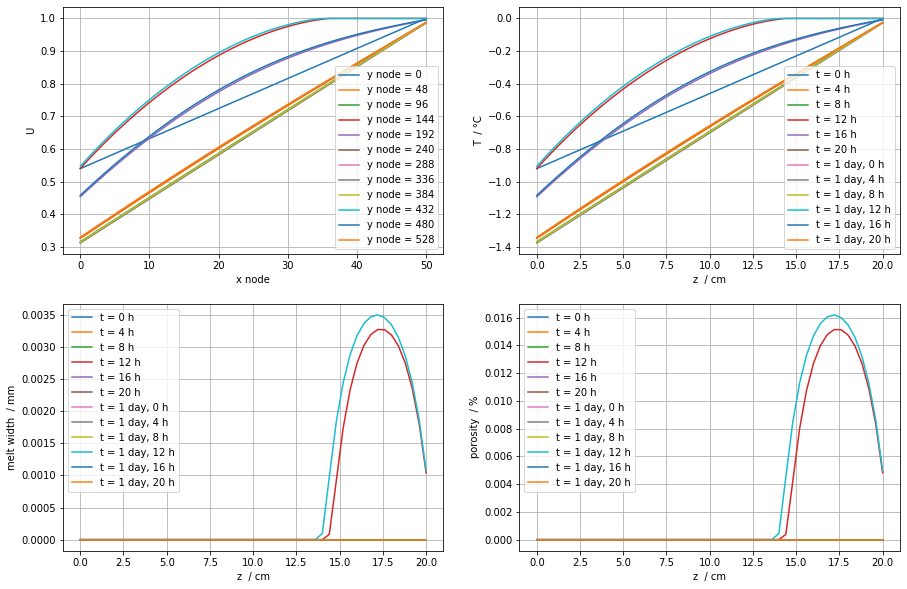

In [16]:
TSoln = myIce.makeUOneD(USoln)

z = np.linspace(0, spatialNodeCount, spatialNodeCount)*myIce._h/spatialNodeCount*100  # cm

plotInterval = 4  # h
idxInterval = (plotInterval*3600)//timeStep

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
for j in list(range(len(USoln)))[::idxInterval]:
    timeLabel = 't = '+'{} h'.format(str(dateTimes[j]-dateTimes[0])[:-6])
    i, k = 0, 0
    axs[i, k].plot(range(spatialNodeCount), USoln[j, :], label='y node = '+'{}'.format(j))
    i, k = 0, 1
    axs[i, k].plot(z, TSoln[j, :], label=timeLabel)
    i, k = 1, 1
    axs[i, k].plot(z, epsSoln[j, :]*100, label=timeLabel)
    i, k = 1, 0
    axs[i, k].plot(z, epsSoln[j, :]*geom.area('hex', [myIce._crystSize])/geom.periphery('hex', [myIce._crystSize])*1000, label=timeLabel)
i, k = 0, 0
axs[i, k].set_xlabel('x node')
axs[i, k].set_ylabel('U')
i, k = 0, 1
axs[i, k].set_xlabel('z  / cm')
axs[i, k].set_ylabel('T  / °C')
i, k = 1, 1
axs[i, k].set_xlabel('z  / cm')
axs[i, k].set_ylabel('porosity  / %')
i, k = 1, 0
axs[i, k].set_xlabel('z  / cm')
axs[i, k].set_ylabel('melt width  / mm')
for i in range(2):
    for k in range(2):
        axs[i, k].legend()
        axs[i, k].grid()

No handles with labels found to put in legend.


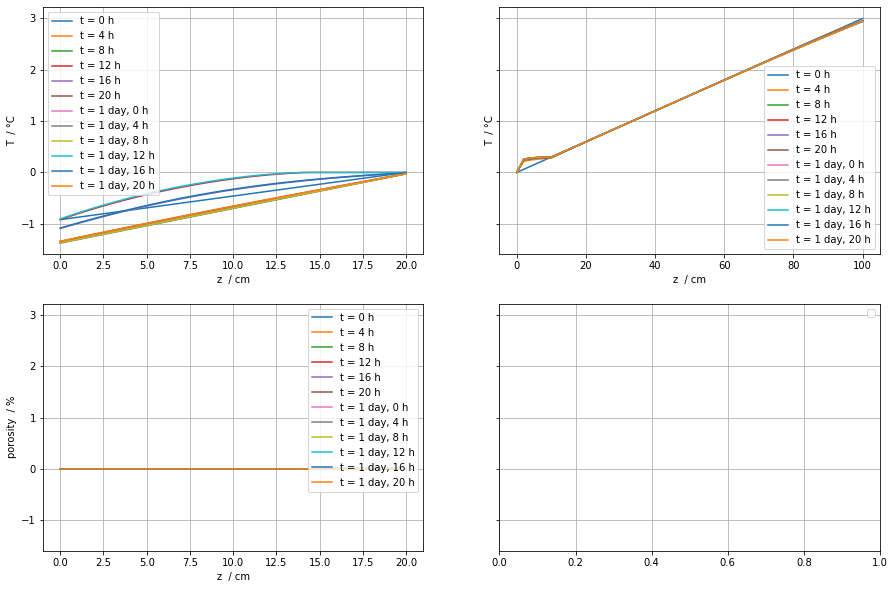

In [17]:
TSoln = myIce.makeUOneD(USoln)
TSolnW = myWater.makeUOneD(USolnW)

z = np.linspace(0, spatialNodeCount, spatialNodeCount)*myIce._h/spatialNodeCount*100  # cm
zW = np.linspace(0, spatialNodeCount, spatialNodeCount)*myWater._h/spatialNodeCount*100  # cm

plotInterval = 4  # h
idxInterval = (plotInterval*3600)//timeStep

fig, axs = plt.subplots(2, 2, sharey=True, figsize=(15, 10))
for j in list(range(len(USoln)))[::idxInterval]:
    timeLabel = 't = '+'{} h'.format(str(dateTimes[j]-dateTimes[0])[:-6])
    i, k = 0, 0
    axs[i, k].plot(z, TSoln[j, :], label=timeLabel)
    i, k = 0, 1
    axs[i, k].plot(zW, TSolnW[j, :], label=timeLabel)
    i, k = 1, 0
    axs[i, k].plot(z, epsSoln[j, :]*100, label=timeLabel)
i, k = 1, 0
axs[i, k].set_xlabel('z  / cm')
axs[i, k].set_ylabel('porosity  / %')
for i in range(2):
    axs[0, k].set_xlabel('z  / cm')
    axs[0, k].set_ylabel('T  / °C')
    for k in range(2):
        axs[i, k].legend()
        axs[i, k].grid()

In [18]:
myWater._IC[0]

0.0

0.1


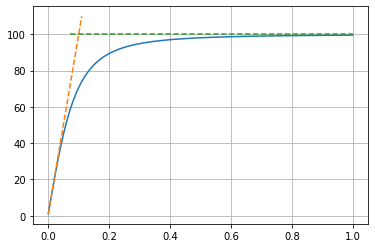

In [19]:
alpha = 10
lmbda = 1
delta = lmbda/alpha
print(delta)

lmbdaeb = 100
dlmbdadz = (lmbdaeb - lmbda)/delta

z = np.linspace(0, 10*delta, 100)
lmbdaew = lmbda + dlmbdadz*z

n = 2
lmbdae = (lmbdaew**(-n) + lmbdaeb**(-n))**(-1/n)

x = np.linspace(0, 1.1*delta, 4)
lmbdaewlim = lmbda + dlmbdadz*x

plt.plot(z, lmbdae)
plt.plot(x, lmbdaewlim, '--')
plt.plot([0.7*delta, 10*delta], [lmbdaeb, lmbdaeb], '--')
plt.grid()

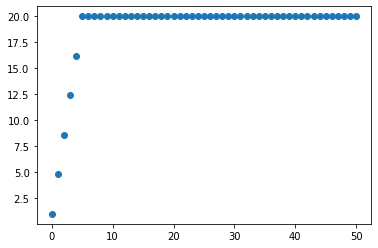

In [21]:
plt.plot(myWater.fEddy(10, 20), 'o')